<a href="https://colab.research.google.com/github/giriragav/UChicago---QCSD/blob/main/lab6_routing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qiskit

In [11]:
# @title Imports
import numpy as np
import networkx as nx
import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit import Qubit
from IPython.display import display

from typing import Dict, Any, List

In [ ]:
# @title Data classes and help functions
# 0.2.0 Wrapping Gates to Make them hashable in a graph structure and give them a unique identifying label
# 0.2.1 Building a new circuit from an old circuit (This is just to see how to use gates from old circuits)
def copy_a_circuit(old_circuit, n):
    '''
    QuantumCircuit's operate on registers of qubits. If the number of qubits in old_circuit is different from the number of qubits in the new circuit
    you need to convert the qubits from old to new.

    This function explains how to copy gates from one set of qubits to another in a different circuit.

    Args:
        old_circuit: the circuit to copy
        n: number of qubits in the new circuit

    '''
    new_circuit = qiskit.QuantumCircuit(n)

    for instr in old_circuit:
        # If n = number of qubits in old_circuit this is O.K.
        # new_circuit.append(instr)

        # If n != number of qubits in old_circuit the above is NOT O.K.
        # Instead, convert the indices
        # DO NOT use both this and the above.
        new_qubit_indices = [instr.qubits[i]._index for i in range(len(instr.qubits))]
        new_circuit.append(instr.operation, new_qubit_indices, instr.clbits)

    return new_circuit

# 0.2.2 Building a Dependency Graph using NetworkX
def build_program_dependency_graph(circuit):
    '''
    Builds a program dependency graph like in the video. Feel free to modify this or build your own as you see fit.
    Here we convert the gates into their hashable versions and add a label.
    '''

    # Starting Label Index
    i = 0

    # A dictionary to store the last use of any qubit
    qubit_last_use = {}

    g = nx.DiGraph()

    # Add the start node
    g.add_node(-1)

    for instr in circuit:

        hashable_gate = GateWrapper(instr.operation, instr.qubits, instr.clbits, label=i)
        i += 1

        g.add_node(hashable_gate)

        # Add edges based on qubit_last_use; update last use
        for qubit in hashable_gate.qubits:
            if qubit in qubit_last_use:
                g.add_edge(qubit_last_use[qubit], hashable_gate)
            else:
                g.add_edge(-1, hashable_gate)

            qubit_last_use[qubit] = hashable_gate

    # Add the end node
    g.add_node(float('inf'))

    for qubit in qubit_last_use:
        g.add_edge(qubit_last_use[qubit], float('inf'))

    return g

# 0.2.3 From Dependency Graph with Hashable Gates to Qiskit Gates
def dependency_graph_to_circuit(dep_graph, n):
    '''
    Takes a dependency graph and the number of qubits n
    '''

    circuit = qiskit.QuantumCircuit(n)

    for gate in nx.topological_sort(dep_graph):

        if gate not in [-1, float('inf')]:
            circuit.append(gate.gate, gate.qubits, gate.extra_params)

    return circuit

# 0.2.4 Interaction Graphs
def interaction_graph_from_circuit(circuit):
    '''
    Builds a weighted interaction graph for a given circuit.

    Nodes are qubits
    Edges are weighted by the number of times pairs of qubits interact
    '''
    g = nx.Graph()

    for instr in circuit:
        for q in instr.qubits:
            g.add_node(q)

        for i in range(len(instr.qubits)):
            for j in range(i):
                q1 = instr.qubits[i]
                q2 = instr.qubits[j]
                if q1 != q2:
                    if (q1, q2) not in g.edges:
                        g.add_edge(q1, q2, weight=1)
                    else:
                        g.edges[q1, q2]['weight'] += 1

    return g

# 0.2.5 Checking if a gate is a certain type
basic_c = QuantumCircuit(1)
basic_c.rz(np.pi / 2, 0)
basic_c.h(0)
basic_c.x(0)

for instr in basic_c:
    if isinstance(instr.operation, qiskit.circuit.library.standard_gates.rz.RZGate):
        print("This is an RZ gate")
    if isinstance(instr.operation, qiskit.circuit.library.standard_gates.HGate):
        print("This is a H gate")
    if isinstance(instr.operation, qiskit.circuit.library.standard_gates.XGate):
        print("This is a X gate")

In [13]:
# @title Visualize functions
# Helper functions to visualize
def draw_interaction_graph(ig):
    nx.draw(nx.relabel_nodes(ig, {q: f'{q._register.name}_{q._index}' for q in ig.nodes}),
            with_labels=True)

def draw_dependency_graph(dep_g):
    nx.draw(dep_g, with_labels=True)

def draw_hardware_graph(target_hardware):
    nx.draw(target_hardware, with_labels=True)

def draw_mapping(target_hardware, mapping):
    rev_mapping = {hw_q: None for hw_q in target_hardware.nodes}
    for k, v in mapping.items():
        assert v in rev_mapping, (
            'Invalid mapping: cannot map a circuit qubit to a non-existant hardware qubit '
            f'({k}->{v} but {v} does not exist)')
        assert rev_mapping[v] is None, (
            'Invalid mapping: cannot map two circuit qubits to the same qubit on hardware '
            f'({rev_mapping[v]}->{v} and {k}->{v})')
        rev_mapping[v] = k
    nx.draw(nx.relabel_nodes(target_hardware,
                             {hw_q: f'''q{getattr(rev_mapping[hw_q], '_index', None)
                                         }->{hw_q}'''
                              for hw_q in target_hardware.nodes}),
            with_labels=True)

def draw_routing(routed_circuit):
    routed_circuit.draw(fold=-1)

In [20]:
####GV Cell
# @title Solution cell
# Do not delete this cell
def checkIfAdjacentNodes(node1, node2, target_hardware):
  if node1 in target_hardware.nodes and node2 in target_hardware.nodes:
    if target_hardware.has_edge(node1, node2):
      return True
  return False

def findAdjacentNodes(node, target_hardware):
  adjNode = []
  for edge in target_hardware.edges:
    if node in edge:
      if edge[0] == node:
        adjNode.append(edge[1])
  return adjNode

def route_circuit_gv(quantum_circuit:QuantumCircuit, target_hardware:nx.Graph,
                  mapping:Dict[Qubit, int]) -> QuantumCircuit:

    new_circuit = QuantumCircuit(len(target_hardware.nodes)-1)
    for instr in quantum_circuit:
      print(instr.operation)

      if len(instr.qubits) == 1:
        circuit_qubit_list = instr.qubits
        print("Single Qubits:", circuit_qubit_list[0]._index, "circuit qubit is used")
        hardware_qubit_id = mapping[circuit_qubit_list[0]]
        #print(hardware_qubit_id)
        new_circuit.append(instr.operation, [circuit_qubit_list[0]._index], instr.clbits)
      elif len(instr.qubits) == 2:
        circuit_qubit_list = instr.qubits
        print("Two Qubits:", circuit_qubit_list[0]._index, "and", circuit_qubit_list[1]._index, "circuit qubits are used. ", end="")
        hardware_qubit1_id = mapping[circuit_qubit_list[0]]
        hardware_qubit2_id = mapping[circuit_qubit_list[1]]
        # checkIsAdjacent = checkIfAdjacentNodes(circuit_qubit_list[0]._index, circuit_qubit_list[1]._index, target_hardware)
        checkIsAdjacent = checkIfAdjacentNodes(hardware_qubit1_id, hardware_qubit2_id, target_hardware)
        if not checkIsAdjacent:
          ## Add Swap there
          print("Hardware qubits:",hardware_qubit1_id, "and", hardware_qubit2_id, "are not an adjacent and do SWAP")
          #print("Add Swap there")
          #adjacentNode = findAdjacentNodes(circuit_qubit_list[0]._index,target_hardware)
          adjacentNode = findAdjacentNodes(hardware_qubit1_id,target_hardware)
          # new_circuit.swap(circuit_qubit_list[0]._index,circuit_qubit_list[1]._index)
          # new_circuit.append(instr.operation, [circuit_qubit_list[0]._index, circuit_qubit_list[1]._index], instr.clbits)
          new_circuit.swap(adjacentNode,circuit_qubit_list[1]._index)
          new_circuit.append(instr.operation, [circuit_qubit_list[0]._index,adjacentNode[0]], instr.clbits)
          new_circuit.swap(adjacentNode,circuit_qubit_list[1]._index)
          ## Add Swap back
          #print("Add Swap back")
        elif checkIsAdjacent:
          print("Hardware qubits:",hardware_qubit1_id, "and", hardware_qubit2_id, "are adjacent")
          new_circuit.append(instr.operation, [circuit_qubit_list[0]._index, circuit_qubit_list[1]._index], instr.clbits)
    return new_circuit

In [14]:
# @title Validation and scoring

def validate_routing_gv(circuit, target_hardware, mapping, routed_circuit, check_unitary=True):
    '''Set check_unitary=False for circuits with over 10 qubits.'''
    # Check other arguments
    assert isinstance(circuit, QuantumCircuit)
    assert isinstance(target_hardware, nx.Graph)
    assert isinstance(mapping, dict)
    qubits = frozenset(q for q in circuit.qubits)
    assert len(circuit.qubits) == len(qubits), 'Unsupported: circuits with multiple registers'
    assert all(isinstance(q, Qubit) for q in qubits)
    assert len(qubits) <= len(target_hardware.nodes), 'Not enough qubits in the hardware'
    assert all(isinstance(hw_q, int) for hw_q in target_hardware.nodes), 'Unsupported: non-int hardware qubit ids'
    # Check unitary
    if check_unitary:  # Slow for circuits with more than 10 qubits
        extended_circuit = QuantumCircuit(len(target_hardware.nodes))
        for instr in circuit:
            extended_qubits = [extended_circuit.qubits[q._index]
                               for q in instr.qubits]
            extended_circuit.append(instr.operation, extended_qubits, instr.clbits)
        unmapped_circuit = QuantumCircuit(len(target_hardware.nodes))
        rev_mapping = {v: k._index for k, v in mapping.items()}
        print(1)
        print(rev_mapping)
        print(2)
        for instr in routed_circuit:
            print(instr)
            unmapped_qubits = [unmapped_circuit.qubits[rev_mapping.get(q._index, q._index)]
                               for q in instr.qubits]
            print(unmapped_qubits)
            unmapped_circuit.append(instr.operation, unmapped_qubits, instr.clbits)

        from qiskit.quantum_info.operators.predicates import matrix_equal
        unitary = lambda c: qiskit.quantum_info.Operator(c).data

        print("unmapped")
        display(unmapped_circuit.draw(fold=-1))
        print("extended")
        display(extended_circuit.draw(fold=-1))
        #print(unitary(unmapped_circuit), unitary(extended_circuit))

        # printMatrix(unitary(unmapped_circuit))
        # printMatrix(unitary(extended_circuit))
        assert matrix_equal(unitary(unmapped_circuit), unitary(extended_circuit)), (
            'Circuits are not eqivalent (for this test, make sure to include '
            'any unnessesary SWAP gates at the end of the circuit to ensure the '
            'qubits are moved back to their starting locations.)')
    # Check valid gates
    print("validation starts for gates")
    for edge in target_hardware.edges:
        print(edge)
    for instr in routed_circuit:
        print(instr)
        if len(instr.qubits) < 2: continue  # Ignore single-qubit gates
        assert len(instr.qubits) <= 2, (
            f'Invalid gate {instr}: the routed circuit should not contain '
            f'3-qubit or larger gates')
        # Check connectivity of the two-qubit gate
        q1, q2 = instr.qubits
        assert (q1._index, q2._index) in target_hardware.edges, (
            f'Invalid gate {instr}: the routed circuit should not contain '
            f'two-qubits gates on pairs of non-adjacent qubits (in the '
            f'target_hardware graph)')

def score_routing_gv(circuit, target_hardware, mapping, routed_circuit):
    '''
    Computes a score that counts the number of SWAPs needed for this routing.
    (Actually counts the number of extra CNOTs divided by 3.)

    Returns the tuple (your score, swap-there-and-back score).  Lower values are better.

    *This should be equal (or maybe a bit lower) than your score for part 1.*
    '''
    validate_routing_gv(circuit, target_hardware, mapping, routed_circuit, check_unitary=False)

    def count_cnots_in_circuit(c):
        pm = qiskit.transpiler.PassManager([
                qiskit.transpiler.passes.BasisTranslator(qiskit.circuit.equivalence_library.SessionEquivalenceLibrary, ['u3', 'cx'])
            ])
        c2 = pm.run(c)
        count = sum(isinstance(instr.operation, qiskit.circuit.library.standard_gates.x.CXGate)
                    for instr in c2)
        return count

    old_cnot_count = count_cnots_in_circuit(circuit)
    new_cnot_count = count_cnots_in_circuit(routed_circuit)
    score = round((new_cnot_count - old_cnot_count) / 3, 3)
    if score == int(score): score = int(score)
    assert score >= 0, 'The schedule does not contain enough gates.'

    # Calculate target score assuming swap-there-and-back routing
    ig = interaction_graph_from_circuit(circuit)
    shortest_paths = dict(nx.all_pairs_shortest_path_length(target_hardware))
    target_score = 0
    for q1, q2 in ig.edges:
        hw_q1 = mapping[q1]
        hw_q2 = mapping[q2]
        dist = shortest_paths[hw_q1][hw_q2]
        cnot_count = ig[q1][q2]['weight']
        target_score += (dist-1) * 2 * cnot_count
    print(f'Your routing score is {score} SWAPs.')
    print(f'(You should have gotten {target_score} SWAPs if you used the '
          f'swap-there-and-back routing strategy.)')
    return score, target_score

Instruction(name='cx', num_qubits=2, num_clbits=0, params=[])
Two Qubits: 0 and 1 circuit qubits are used. Hardware qubits: 0 and 3 are adjacent


q_0: ──■──
     ┌─┴─┐
q_1: ┤ X ├
     └───┘

q_0: ──■──
     ┌─┴─┐
q_1: ┤ X ├
     └───┘
q_2: ─────

1
{0: 0, 3: 1}
2
CircuitInstruction(operation=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qubits=(<Qubit register=(3, "q"), index=0>, <Qubit register=(3, "q"), index=1>), clbits=())
[<Qubit register=(4, "q"), index=0>, <Qubit register=(4, "q"), index=1>]
unmapped


q_0: ──■──
     ┌─┴─┐
q_1: ┤ X ├
     └───┘
q_2: ─────
          
q_3: ─────

extended


q_0: ──■──
     ┌─┴─┐
q_1: ┤ X ├
     └───┘
q_2: ─────
          
q_3: ─────

validation starts for gates
(0, 1)
(1, 2)
(2, 3)
CircuitInstruction(operation=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qubits=(<Qubit register=(3, "q"), index=0>, <Qubit register=(3, "q"), index=1>), clbits=())
validation starts for gates
(0, 1)
(1, 2)
(2, 3)
CircuitInstruction(operation=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qubits=(<Qubit register=(3, "q"), index=0>, <Qubit register=(3, "q"), index=1>), clbits=())
Your routing score is 0 SWAPs.
(You should have gotten 4 SWAPs if you used the swap-there-and-back routing strategy.)
PASS: Valid circuit routing


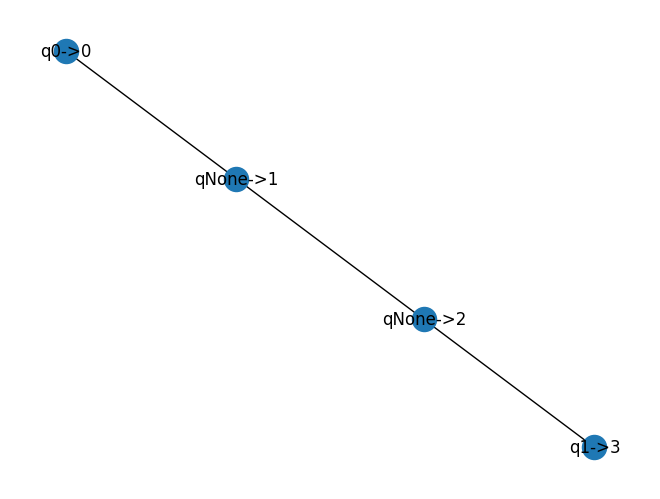

In [19]:
# @title 1 CNOT tests
# GV Cell for testing 1 CNOT mappings
def test1Cnot():
  _hardware1 = nx.path_graph(4)
  _cuccaro61 = QuantumCircuit.from_qasm_str('OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[2];\ncx q[0],q[1];\n')
  _mapping1 = {Qubit(QuantumRegister(2, 'q'), 0): 0,
              Qubit(QuantumRegister(2, 'q'), 1): 3}
  _routing1 = route_circuit_gv(_cuccaro61, _hardware1, _mapping1)  # Run your code
  display(_cuccaro61.draw(fold=-1))
  display(_routing1.draw(fold=-1))
  draw_mapping(_hardware1, _mapping1)
  validate_routing_gv(_cuccaro61, _hardware1, _mapping1, _routing1)
  score_routing_gv(_cuccaro61, _hardware1, _mapping1, _routing1)
  print('PASS: Valid circuit routing')
test1Cnot()